#Intalação de Pacotes

In [3]:
!pip install -q yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.2 MB/s eta 0:00:00


In [4]:

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

## Funções

In [5]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)
  
  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except: 
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [6]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS') 
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')    
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [7]:
def busca_informes_diarios_cvm_antes21(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim) 
  informe_completoh = pd.DataFrame()

  for data in datas:
    try:
      url ='https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/inf_diario_fi_{}.zip'.format(data.year)
      informe_mensalh = pd.read_csv(url, sep=';')
         
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completoh = pd.concat([informe_completoh, informe_mensalh], ignore_index=True)
  return informe_completoh

In [8]:
def melhores_e_piores(informes, cadastro, top=66, minimo_de_cotistas=33, classe=''):  
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()
  
  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')  
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]
  
  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']   
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  
  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]
  
  return melhores, piores

In [9]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [10]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [11]:
def selic_acumulada(data_inicio, data_fim):
  codigo_bcb = 4390
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  selic = pd.read_json(url)
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  selic.set_index('data', inplace=True) 
  
  selic_acumulada = (1 + selic[data_inicio : data_fim] / 100).cumprod()
  selic_acumulada.iloc[0] = 1
  return selic_acumulada

## Benckmarks

In [12]:
cdi = cdi_acumulado('2021-01-01', '2022-03-04') * 100
cdi

,valor
data,
2021-01-04,100.000000
2021-01-05,100.014939
2021-01-06,100.022409
2021-01-07,100.029879
2021-01-08,100.037351
...,...
2022-02-24,105.939944
2022-02-25,105.982498
2022-03-02,106.025069


In [16]:
selic= selic_acumulada('2020-01-01', '2020-10-01') * 100
selic

,valor
data,
2020-01-01,100.000000
2020-02-01,100.671102
2020-03-01,101.013384
2020-04-01,101.296221
2020-05-01,101.539332
2020-06-01,101.752565
2020-07-01,101.945895
2020-08-01,102.109008
2020-09-01,102.272382


In [17]:
ibov = yf.download('^BVSP', start='2021-01-01', end='2022-03-04')['Close']
ibov = (ibov / ibov.iloc[0])*100
ibov

[*********************100%***********************]  1 of 1 completed


Date
2021-01-04    100.000000
2021-01-05    100.560907
2021-01-06    101.090605
2021-01-07    102.866108
2021-01-08    105.498575
                 ...    
2022-02-23     94.475278
2022-02-24     94.124395
2022-02-25     95.431772
2022-03-02     97.145701
2022-03-03     97.138953
Name: Close, Length: 289, dtype: float64

## Buscando Dados da CVM

In [18]:
cadastro = busca_cadastro_cvm()
cadastro

,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCEIRO - MAX,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INVESTIMENTO,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC 60 DIAS URV,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIMENTO FINANCEIRO,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71152,FUNCINE,28.850.140/0001-78,FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE - TIM,2017-10-16,2017-10-06,417001.0,NaN,EM FUNCIONAMENTO NORMAL,2017-12-26,2017-12-26,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71153,FUNCINE,28.912.043/0001-62,HAPVIDA - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL - FUNCINE,2017-10-27,2017-10-19,417003.0,NaN,EM FUNCIONAMENTO NORMAL,2018-12-21,2018-12-21,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71154,FUNCINE,31.674.280/0001-47,MEDIA VENTURE ESG INCENTIVADO - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL,2018-10-26,2018-09-13,418001.0,NaN,EM FUNCIONAMENTO NORMAL,2022-12-26,2022-12-26,...,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,16.549.480/0001-84,RSM BRASIL AUDITORES INDEPENDENTES - SOCIEDADE SIMPLES,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN
71155,FUNCINE,32.222.962/0001-81,Fundo de Financiamento da Indústria Cinematográfica Nacional de Minas Gerais,2018-12-20,2018-11-14,418002.0,2021-10-29,CANCELADA,2021-10-29,NaN,...,INTRA INVESTIMENTOS DTVM LTDA,PJ,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES LTDA.,15.489.568/0001-95,INTRA INVESTIMENTOS DTVM LTDA,NaN,NaN


In [19]:
#informe_hi = busca_informes_diarios_cvm_antes21(data_inicio='2013', data_fim='2020')
#informe_hi


In [20]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2021-01', data_fim='2022-03')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2021-01-04,1097664.87,27.503336,1095773.57,0.0,0.0,1
1,FI,00.017.024/0001-53,2021-01-05,1097742.61,27.503455,1095778.31,0.0,0.0,1
2,FI,00.017.024/0001-53,2021-01-06,1097837.04,27.503196,1095768.02,0.0,0.0,1
3,FI,00.017.024/0001-53,2021-01-07,1097939.54,27.503352,1095774.20,0.0,0.0,1
4,FI,00.017.024/0001-53,2021-01-08,1096790.38,27.503710,1095788.49,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
6736163,FI,97.929.213/0001-34,2022-03-25,72973880.29,9.601337,72963645.88,0.0,0.0,2
6736164,FI,97.929.213/0001-34,2022-03-28,73011911.38,9.606289,73001275.99,0.0,0.0,2
6736165,FI,97.929.213/0001-34,2022-03-29,72973008.18,9.604625,72988633.14,0.0,0.0,2
6736166,FI,97.929.213/0001-34,2022-03-30,72867250.91,9.587158,72855897.94,0.0,0.0,2


#Filtro FundoTCE

In [21]:
austro= informes.loc[informes['CNPJ_FUNDO']=='18.366.002/0001-64']

In [22]:
austro

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
140354,FI,18.366.002/0001-64,2021-01-04,86206440.26,1.373842,80468738.42,0.0,0.00,33
140355,FI,18.366.002/0001-64,2021-01-05,86200504.38,1.373650,80457480.95,0.0,0.00,33
140356,FI,18.366.002/0001-64,2021-01-06,86194568.85,1.373458,80446224.55,0.0,0.00,33
140357,FI,18.366.002/0001-64,2021-01-07,86188633.70,1.373266,80434969.25,0.0,0.00,33
140358,FI,18.366.002/0001-64,2021-01-08,86182698.91,1.373073,80423715.04,0.0,0.00,33
...,...,...,...,...,...,...,...,...,...
5916457,FI,18.366.002/0001-64,2022-02-25,15473390.59,0.970290,8555747.25,0.0,0.00,33
6373370,FI,18.366.002/0001-64,2022-03-02,15473390.59,0.970195,8554910.72,0.0,0.00,33
6373371,FI,18.366.002/0001-64,2022-03-03,15473390.59,0.970100,8554074.24,0.0,0.00,33
6373372,FI,18.366.002/0001-64,2022-03-04,0.00,0.970005,0.00,0.0,8553237.87,0


In [23]:
#Transformar o index em data

In [24]:
#austro.index = pd.to_datetime(austro.index, format="%d/%m/%Y")

In [25]:
austro['cotan']= austro['VL_QUOTA']/austro['VL_QUOTA'].iloc[0]*100

In [26]:
austro


,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,cotan
140354,FI,18.366.002/0001-64,2021-01-04,86206440.26,1.373842,80468738.42,0.0,0.00,33,100.000000
140355,FI,18.366.002/0001-64,2021-01-05,86200504.38,1.373650,80457480.95,0.0,0.00,33,99.986010
140356,FI,18.366.002/0001-64,2021-01-06,86194568.85,1.373458,80446224.55,0.0,0.00,33,99.972022
140357,FI,18.366.002/0001-64,2021-01-07,86188633.70,1.373266,80434969.25,0.0,0.00,33,99.958034
140358,FI,18.366.002/0001-64,2021-01-08,86182698.91,1.373073,80423715.04,0.0,0.00,33,99.944049
...,...,...,...,...,...,...,...,...,...,...
5916457,FI,18.366.002/0001-64,2022-02-25,15473390.59,0.970290,8555747.25,0.0,0.00,33,70.626010
6373370,FI,18.366.002/0001-64,2022-03-02,15473390.59,0.970195,8554910.72,0.0,0.00,33,70.619104
6373371,FI,18.366.002/0001-64,2022-03-03,15473390.59,0.970100,8554074.24,0.0,0.00,33,70.612199
6373372,FI,18.366.002/0001-64,2022-03-04,0.00,0.970005,0.00,0.0,8553237.87,0,70.605295


#FUNDOS MULTIMERCADO

In [27]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='multimercado')


In [28]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
37.927.641/0001-04,77.617680,BTG PACTUAL ECONOMIA REAL FEEDER I FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,2.376177e+08
27.945.399/0001-30,77.379228,CRESCERA GROWTH ADVISORY FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,8.048803e+07
37.681.227/0001-50,77.318106,BTG PACTUAL ECONOMIA REAL FEEDER FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,1.408818e+08
37.660.648/0001-02,74.051584,WARREN ORÁCULO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO - CRED PRIV,Fundo Multimercado,1.529246e+07
21.646.715/0001-96,60.506697,VISTA MULTIESTRATÉGIA FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO,Fundo Multimercado,6.655377e+08


#exporta para excell

In [29]:
piores.to_excel(r'C:\Users\Felipe\Desktop\export_dataframe.xlsx', index=False)

#Gráfico

In [30]:
cotas = pd.DataFrame()
fundos_destaque = melhores
for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [31]:
cotas

Fundo de Investimento,BTG PACTUAL ECONOMIA REAL FEEDER I FUNDO DE INVESTIMENTO MULTIMERCADO,CRESCERA GROWTH ADVISORY FUNDO DE INVESTIMENTO MULTIMERCADO,BTG PACTUAL ECONOMIA REAL FEEDER FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO,WARREN ORÁCULO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO - CRED PRIV,VISTA MULTIESTRATÉGIA FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,100.003175,100.000000,100.002169,99.999387,103.528827
2021-01-06,100.006794,100.000000,100.004771,100.005899,101.178470
2021-01-07,100.010221,100.000000,100.007192,100.012479,100.873501
2021-01-08,100.013023,100.000000,100.009028,100.018998,101.437011
...,...,...,...,...,...
2022-03-25,176.997478,181.061480,176.704789,174.055296,162.127488
2022-03-28,176.998032,181.061480,176.703478,174.054397,155.586924
2022-03-29,176.998728,181.061480,176.702308,174.053531,158.986147
2022-03-30,177.616995,181.061480,177.319206,174.052368,160.713486


In [32]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=austro['DT_COMPTC'], y=austro['cotan'], name='Austro', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos multimercado')
fig.update_layout(legend_orientation="h")

fig.show()

In [33]:
cotas = pd.DataFrame()
fundos_destaque = piores
for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [34]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Piores Fundos multimercado')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos de Ações

In [35]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='acoes')

In [36]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
36.327.455/0001-63,53.057180,TREND BOLSA AMERICANA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,4.802970e+07
29.177.024/0001-00,48.750040,TRIGONO DELPHOS INCOME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,Fundo de Ações,4.351184e+08
03.917.778/0001-58,42.485824,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,Fundo de Ações,2.747599e+08
29.177.013/0001-12,42.059053,TRIGONO FLAGSHIP SMALL CAPS FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,Fundo de Ações,2.168863e+08
03.914.671/0001-56,41.427907,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA PETROBRAS,Fundo de Ações,6.663029e+08


In [37]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
13.199.100/0001-30,-72.955896,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,Fundo de Ações,5038211.65
13.476.201/0001-01,-49.471803,FATOR SINERGIA FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,6970731.85
34.218.661/0001-00,-46.868807,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,Fundo de Ações,31593679.74
47.177.431/0001-91,-39.650478,ALFA - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES,Fundo de Ações,2751190.45
24.874.367/0001-00,-37.364311,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES,Fundo de Ações,33286448.11


### Graficos

In [38]:
cotas = pd.DataFrame()
fundos_destaque = pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [39]:
cotas

Fundo de Investimento,TREND BOLSA AMERICANA ALAVANCADO FUNDO DE INVESTIMENTO EM AÇÕES,TRIGONO DELPHOS INCOME FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,ITAÚ AÇÕES PETROBRÁS - FUNDO DE INVESTIMENTO,TRIGONO FLAGSHIP SMALL CAPS FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM ACOES,FUNDO DE INVESTIMENTO EM AÇÕES CAIXA PETROBRAS,SANTANDER FUNDO DE INVESTIMENTO COLABORADORES MAGAZINE LUIZA AÇÕES,FATOR SINERGIA FUNDO DE INVESTIMENTO EM AÇÕES,VITREO CANABIDIOL FUNDO DE INVESTIMENTO EM AÇÕES INVESTIMENTO NO EXTERIOR,ALFA - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO EM AÇÕES,INTER + IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,101.378680,100.497042,103.044585,100.555729,103.037603,98.256501,99.547414,103.153722,100.306108,100.422139
2021-01-06,103.221351,101.660324,104.057359,101.290333,104.045668,93.028790,96.746187,109.798394,99.610257,98.330462
2021-01-07,105.610775,104.295463,107.271083,103.545521,107.252857,91.918873,95.331766,114.862994,101.892324,102.271979
2021-01-08,106.378456,105.948092,107.064323,105.509296,107.043875,94.610275,97.420692,116.081614,104.153581,107.805198
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,152.827614,149.578346,141.534032,142.586767,140.508906,25.938366,49.675346,53.986165,60.527674,64.131315
2022-03-28,154.933135,148.864905,137.812883,142.247662,136.805482,25.661889,49.319138,52.646115,60.527357,62.859432
2022-03-29,158.819543,150.390324,139.505307,144.396783,138.479467,27.754124,51.331605,53.833907,61.063959,66.734738
2022-03-30,157.251446,149.226902,141.965118,142.982243,140.915457,27.241482,50.714235,53.731780,60.712737,64.966388


In [40]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores e Piores Fundos de Ações do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

## Fundos Cambial


In [41]:
melhores, piores = melhores_e_piores(informes, cadastro, top=5, minimo_de_cotistas=100, classe='cambial')

In [42]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
32.246.789/0001-51,20.699835,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.571737e+07
20.077.065/0001-42,-6.992345,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,1.346656e+07
04.061.044/0001-82,-8.237853,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,5.298000e+08
04.128.893/0001-06,-8.457377,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,2.819123e+08
33.144.687/0001-98,-8.855688,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,2.808085e+08


In [43]:
piores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
04.305.193/0001-40,-18.651353,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo Cambial,83567966.58
37.569.678/0001-08,-15.867292,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,Fundo Cambial,17185594.13
00.819.855/0001-49,-12.340895,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,Fundo Cambial,1053675.65
01.171.956/0001-19,-12.143966,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,Fundo Cambial,5481889.98
05.495.393/0001-75,-10.679392,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL,Fundo Cambial,11004231.10


### Grafico de Cotas

In [44]:
cotas = pd.DataFrame()
fundos_destaque =  pd.concat([melhores, piores])

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [45]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,99.679415,100.322822,100.369457,100.368638,100.341475,102.459595,100.830407,100.317738,100.326317,100.324703
2021-01-06,99.825633,100.201594,100.242649,100.240899,100.216021,102.612523,100.693730,100.181100,100.186851,100.192022
2021-01-07,97.285640,102.636634,102.806850,102.804374,102.796777,103.211369,102.573487,102.685613,102.749018,102.711749
2021-01-08,96.693660,103.250873,103.449137,103.445874,103.449751,103.605218,103.111924,103.300614,103.386335,103.341973
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,120.408840,92.934995,91.673822,91.457377,91.087966,81.392992,83.797791,87.661199,87.846151,89.285040
2022-03-28,120.076107,93.258293,92.009840,91.792056,91.417976,81.401579,83.631446,87.780478,88.151551,89.595841
2022-03-29,120.306701,93.163172,91.914525,91.696201,91.317329,81.645045,83.895949,87.845613,88.042204,89.493071
2022-03-30,120.165848,93.331929,92.085864,91.866374,91.486576,82.086720,84.463930,87.990072,88.194194,89.655409


In [46]:
cotas

Fundo de Investimento,TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL,MAPFRE FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL,BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL,WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR,SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL
2021-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2021-01-05,99.679415,100.322822,100.369457,100.368638,100.341475,102.459595,100.830407,100.317738,100.326317,100.324703
2021-01-06,99.825633,100.201594,100.242649,100.240899,100.216021,102.612523,100.693730,100.181100,100.186851,100.192022
2021-01-07,97.285640,102.636634,102.806850,102.804374,102.796777,103.211369,102.573487,102.685613,102.749018,102.711749
2021-01-08,96.693660,103.250873,103.449137,103.445874,103.449751,103.605218,103.111924,103.300614,103.386335,103.341973
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,120.408840,92.934995,91.673822,91.457377,91.087966,81.392992,83.797791,87.661199,87.846151,89.285040
2022-03-28,120.076107,93.258293,92.009840,91.792056,91.417976,81.401579,83.631446,87.780478,88.151551,89.595841
2022-03-29,120.306701,93.163172,91.914525,91.696201,91.317329,81.645045,83.895949,87.845613,88.042204,89.493071
2022-03-30,120.165848,93.331929,92.085864,91.866374,91.486576,82.086720,84.463930,87.990072,88.194194,89.655409


In [47]:
ibov

Date
2021-01-04    100.000000
2021-01-05    100.560907
2021-01-06    101.090605
2021-01-07    102.866108
2021-01-08    105.498575
                 ...    
2022-02-23     94.475278
2022-02-24     94.124395
2022-02-25     95.431772
2022-03-02     97.145701
2022-03-03     97.138953
Name: Close, Length: 289, dtype: float64

In [48]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]

fig.add_trace(go.Scatter(x=ibov.index, y=ibov, name='IBOV', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos Cambiais do 1º Semestre de 2022')
fig.update_layout(legend_orientation="h")

fig.show()

In [49]:
cotas.columns

Index(['TREND SHORT DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'MAPFRE FUNDO DE INVESTIMENTO CAMBIAL',
       'BB CAMBIAL DÓLAR LP VIP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BB CAMBIAL DOLAR LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'BTG PACTUAL DIGITAL DOLAR FUNDO DE INVESTIMENTO CAMBIAL',
       'BB CAMBIAL EURO LP FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO',
       'VITREO MOEDAS LIFE FUNDO DE INVESTIMENTO CAMBIAL',
       'WESTERN ASSET CÂMBIO DOLAR SILVER FICFI CAMBIAL',
       'BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL DÓLAR',
       'SAFRA CAMBIAL SUPER - FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO CAMBIAL'],
      dtype='object', name='Fundo de Investimento')

### Correlação

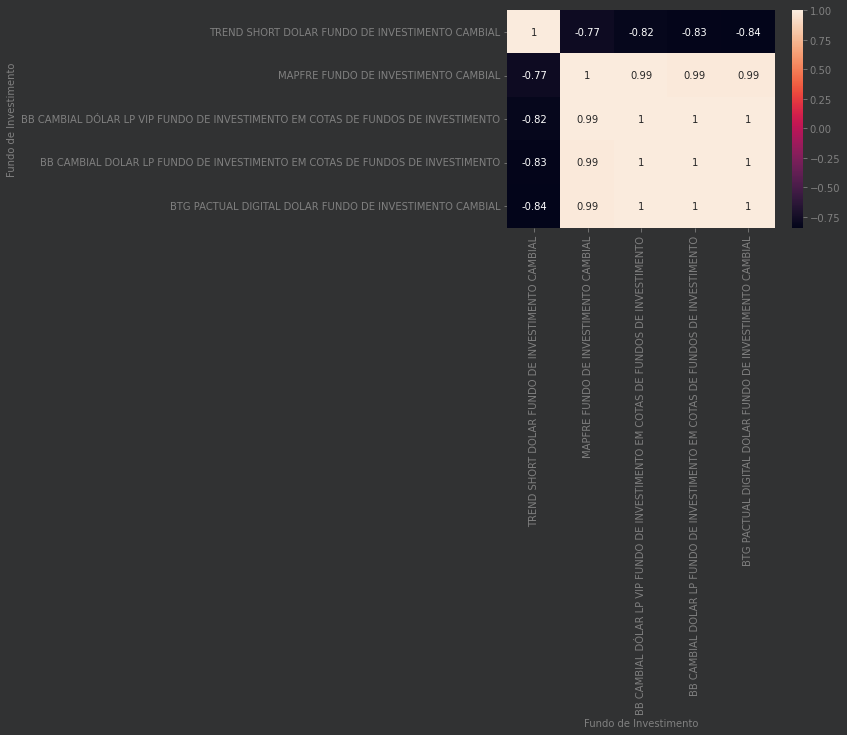

In [50]:
sns.heatmap(cotas.iloc[:, :5].corr(), annot=True);

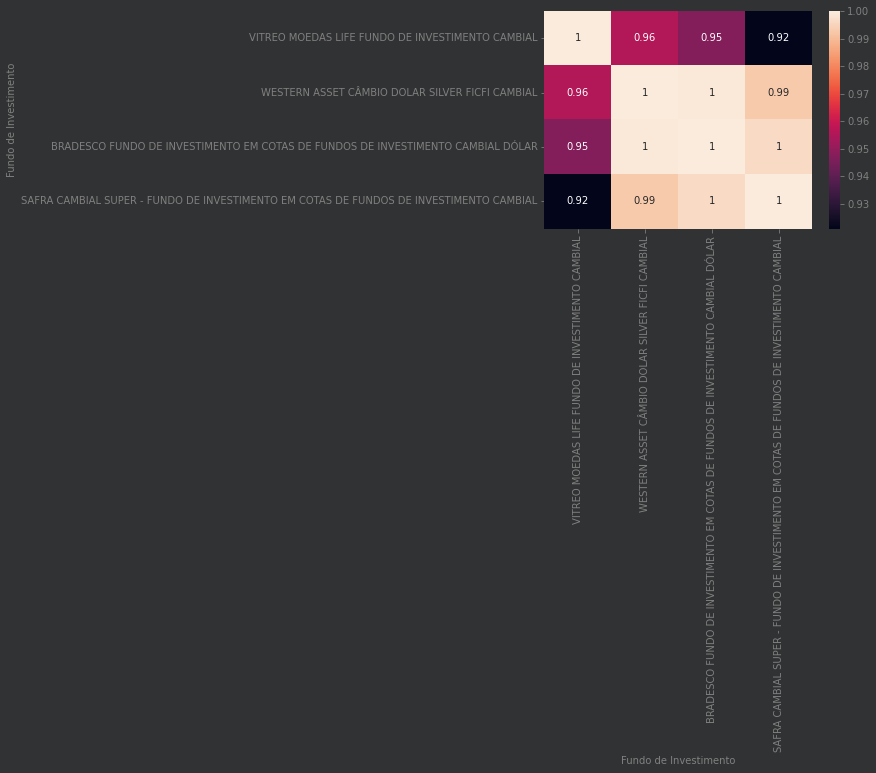

In [51]:
sns.heatmap(cotas.iloc[:, 6:].corr(), annot=True);

In [52]:
#BACKTESTING

In [53]:
#Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab_Notebooks/Financas/Fundos/analise/fi/Analise-Fundos-de-Investimento-main')

In [55]:
#Dados do fundo
f=pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/Financas/Fundos/analise/fi/Analise-Fundos-de-Investimento-main/Análise de Desempenho - Notebooks/austro.xlsx', index_col='data')

return_serie = f["cota"].pct_change(1).dropna()
return_serie.name = "return"

In [56]:
#sortino


# Cálculo do sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

Sortino: -1.391


In [57]:
# CovariÂncia entre o mercado e o fundo
f1 = yf.download("BOVA11.SA", start="2020-01-01", end="2020-09-30")
BOVA11=f1["Close"].pct_change(1)


# Concatenar
val = pd.concat((return_serie, BOVA11), axis=1).dropna()

# We compute beta 
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: -0.023


In [58]:
# Cálculo do alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: -22.7


In [59]:
def drawdown_function(serie):

  # Máximo dos retornos
  cum = serie.dropna().cumsum() + 1

  # Máximo de ganho do período (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # cálculo do drawdown
  drawdown = cum/running_max - 1
  return drawdown

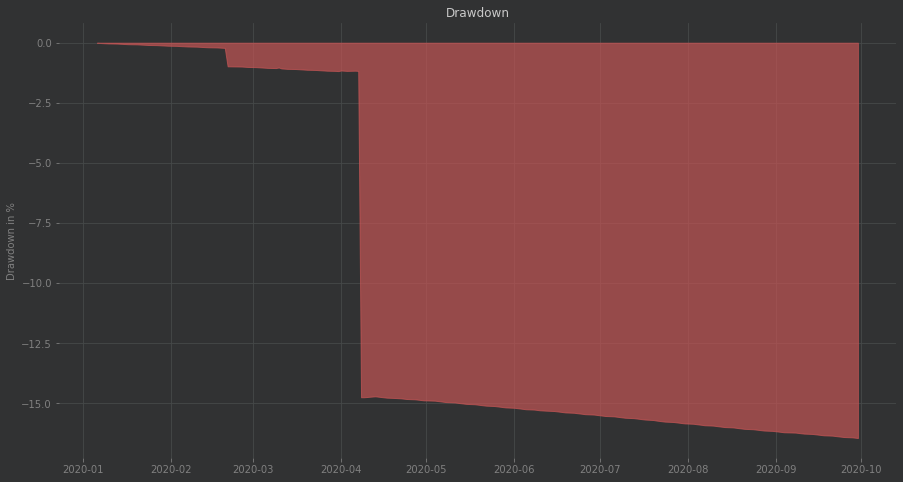

In [60]:
#Cálculo do drawdown
drawdown = drawdown_function(return_serie)

# Adapt figure size
plt.figure(figsize=(15,8))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Put a title
plt.title("Drawdown")

# Put y label
plt.ylabel("Drawdown in %")

plt.show()

In [61]:
#Função Completa

In [62]:
def BackTest(serie, annualiazed_scalar=252):

  # Mercado
  sp500 = yf.download("BOVA11.SA")["Close"].pct_change(1)
  
  # Trocar o nome
  sp500.name = "SP500"

  # Concatenar os retornos com o mercado
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Cálculo do drawdown
  drawdown = drawdown_function(serie)*100
  
  # Computar o drawdown máximo
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Austro", "Mercado"])
  
  # Set individual title
  cum.set_title("Retorno Acumulado", size=13)

  cum.set_ylabel("Retorno Acumulado %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()
  

  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


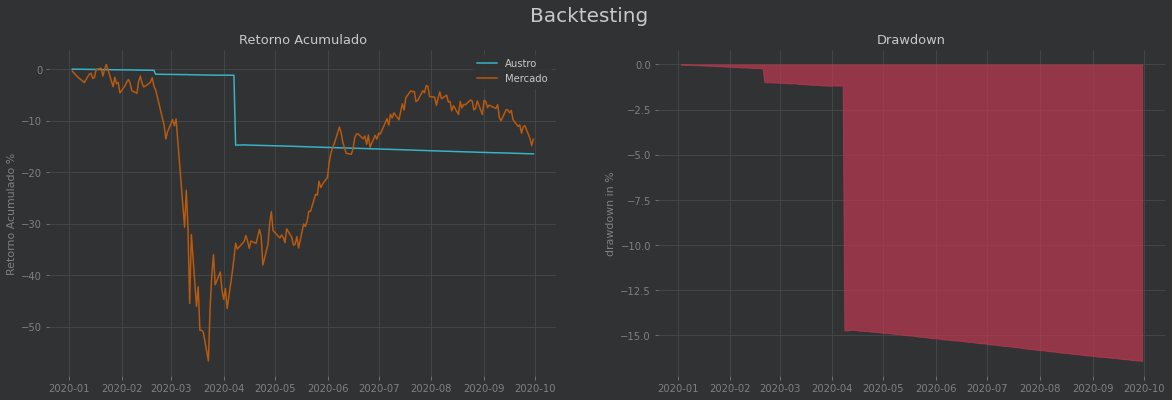

Sortino: -1.387
Beta: -0.023
Alpha: -22.673 %
MaxDrawdown: 16.437 %


In [63]:
BackTest(return_serie, 252)

In [65]:
selic

,valor
data,
2020-01-01,100.000000
2020-02-01,100.671102
2020-03-01,101.013384
2020-04-01,101.296221
2020-05-01,101.539332
2020-06-01,101.752565
2020-07-01,101.945895
2020-08-01,102.109008
2020-09-01,102.272382


In [66]:
f

,cota
data,
2020-01-02,1650324910000
2020-01-03,1650220000000
2020-01-06,1650115950000
2020-01-07,1650011900000
2020-01-08,1649905930000
...,...
2020-09-24,1386735050000
2020-09-25,1386539520000
2020-09-28,1386344010000


In [67]:
austro=(f / f.iloc[0])*100

In [68]:
austro

,cota
data,
2020-01-02,100.000000
2020-01-03,99.993643
2020-01-06,99.987338
2020-01-07,99.981033
2020-01-08,99.974612
...,...
2020-09-24,84.028002
2020-09-25,84.016154
2020-09-28,84.004307


In [69]:
selic

,valor
data,
2020-01-01,100.000000
2020-02-01,100.671102
2020-03-01,101.013384
2020-04-01,101.296221
2020-05-01,101.539332
2020-06-01,101.752565
2020-07-01,101.945895
2020-08-01,102.109008
2020-09-01,102.272382


In [70]:
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import datetime as dt
import plotly.io as pio
pio.templates.default = "ggplot2"

In [71]:
trace0 = go.Scatter(x=austro.index, y=austro.cota, name='Austro', line=dict(color='lime'))
trace1 = go.Scatter(x=selic.index, y=selic.valor, name='Selic', line=dict(color='red'))

fig4 = go.Figure([trace0, trace1])
fig4.update_layout(dict(
    title=dict({
        'text': "Austro vs Selic",
        'x':0.5,
        'xanchor': 'center'}),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=3,
                     label='3m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='12m',
                     step='month',
                     stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date')))
fig4.show()